In [12]:
import torch

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    将源域数据和目标域数据转化为核矩阵，即上文中的K
    Params: 
     source: 源域数据，行表示样本数目，列表示样本数据维度
     target: 目标域数据 同source
     kernel_mul: 多核MMD，以bandwidth为中心，两边扩展的基数，比如bandwidth/kernel_mul, bandwidth, bandwidth*kernel_mul
     kernel_num: 取不同高斯核的数量
     fix_sigma: 是否固定，如果固定，则为单核MMD
    Return:
     sum(kernel_val): 多个核矩阵之和
    '''
    n_samples = int(source.size()[0])+int(target.size()[0])
    # 求矩阵的行数，即两个域的的样本总数，一般source和target的尺度是一样的，这样便于计算
    total = torch.cat([source, target], dim=0)#将source,target按列方向合并
    #将total复制（n+m）份
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    #将total的每一行都复制成（n+m）行，即每个数据都扩展成（n+m）份
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    # total1 - total2 得到的矩阵中坐标（i,j, :）代表total中第i行数据和第j行数据之间的差 
    # sum函数，对第三维进行求和，即平方后再求和，获得高斯核指数部分的分子，是L2范数的平方
    L2_distance_square = ((total0-total1)**2).sum(2) 
    #调整高斯核函数的sigma值
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance_square) / (n_samples**2-n_samples)
    # 多核MMD
    #以fix_sigma为中值，以kernel_mul为倍数取kernel_num个bandwidth值（比如fix_sigma为1时，得到[0.25,0.5,1,2,4]
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    # print(bandwidth_list)
    #高斯核函数的数学表达式
    kernel_val = [torch.exp(-L2_distance_square / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    #得到最终的核矩阵
    return sum(kernel_val)#/len(kernel_val)

In [ ]:
def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    计算源域数据和目标域数据的MMD距离
    Params: 
     source: 源域数据，行表示样本数目，列表示样本数据维度
     target: 目标域数据 同source
     kernel_mul: 多核MMD，以bandwidth为中心，两边扩展的基数，比如bandwidth/kernel_mul, bandwidth, bandwidth*kernel_mul
     kernel_num: 取不同高斯核的数量
     fix_sigma: 是否固定，如果固定，则为单核MMD
 Return:
  loss: MMD loss
    '''
    source_num = int(source.size()[0])#一般默认为源域和目标域的batchsize相同
    target_num = int(target.size()[0])
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    #根据式（3）将核矩阵分成4部分
    XX = torch.mean(kernels[:source_num, :source_num])
    YY = torch.mean(kernels[source_num:, source_num:])
    XY = torch.mean(kernels[:source_num, source_num:])
    YX = torch.mean(kernels[source_num:, :source_num])
    loss = XX + YY -XY - YX
    return loss#因为一般都是n==m，所以L矩阵一般不加入计算

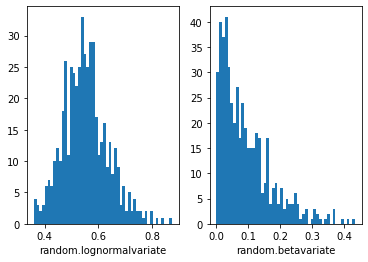

In [2]:
import random
import matplotlib
import matplotlib.pyplot as plt

SAMPLE_SIZE = 500
buckets = 50

#第一种分布：对数正态分布，得到一个中值为mu，标准差为sigma的正态分布。mu可以取任何值，sigma必须大于零。
plt.subplot(1,2,1)
plt.xlabel("random.lognormalvariate")
mu = -0.6
sigma = 0.15#将输出数据限制到0-1之间
res1 = [random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)]
plt.hist(res1, buckets)

#第二种分布：beta分布。参数的条件是alpha 和 beta 都要大于0， 返回值在0~1之间。
plt.subplot(1,2,2)
plt.xlabel("random.betavariate")
alpha = 1
beta = 10
res2 = [random.betavariate(alpha, beta) for _ in range(1, SAMPLE_SIZE)]
plt.hist(res2, buckets)

# plt.savefig('data.jpg')
plt.show()


499 10 torch.Size([10, 499]) torch.Size([10, 499])
tensor(6.1803)


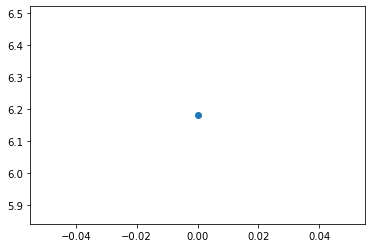

In [3]:
from torch.autograd import Variable

#参数值见上段代码
#分别从对数正态分布和beta分布取两组数据
diff_1 = []
for i in range(10):
    diff_1.append([random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)])

diff_2 = []
for i in range(10):
    diff_2.append([random.betavariate(alpha, beta) for _ in range(1, SAMPLE_SIZE)])

X = torch.Tensor(diff_1)
Y = torch.Tensor(diff_2)
print(len(diff_1[0]), len(diff_2), X.shape, Y.shape)
X,Y = Variable(X), Variable(Y)
print(mmd_rbf(X,Y))
plt.scatter(0, mmd_rbf(X, Y))

In [4]:
import numpy as np
from torch.autograd import Variable

#参数值见以上代码
#从对数正态分布取两组数据
same_1 = []
for i in range(10):
    same_1.append([random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)])

same_2 = []
for i in range(10):
    same_2.append([random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)])

X = torch.Tensor(same_1)
Y = torch.Tensor(same_2)
X,Y = Variable(X), Variable(Y)
# print(mmd_rbf(X,Y))

In [11]:
import numpy as np
import scipy.io
mat = scipy.io.loadmat('Syndata.mat')
data = mat['data']
data.shape

from sklearn.metrics.pairwise import rbf_kernel

K = rbf_kernel(data, data, 0.5/1.8**2)
print(f"K: {K.shape}")
print(K[:10])

def halving(K, m, candidate_index=None, lambda_=0.001):
    
    n = K.shape[0]
    # print(f'number of data: {n}')

    m = min(n, m)
    # print(f'number of samples: {m}')

    if candidate_index is None:
        candidate_index = np.array(range(n))
    
    # print(f'candidate_index: {candidate_index}')

    q = len(candidate_index)

    index = np.empty(m, dtype=int)
    # print(f'number of index: {index.shape}')

    # print('Selecting samples......')
    for i in range(m):
        score = np.zeros(q)
        for j in range(q):
            if candidate_index[j] == -1:
                continue
            else:
                k = candidate_index[j]
                # print(k)
                score[j] = np.dot(K[k, :], K[:, k]) / (K[k, k] + lambda_)
        
        I = score.argmax()
        # print(I)
        index[i] = candidate_index[I]

        candidate_index[I] = -1
        
        # update K
        # K = K - np.dot(K[:, index[i]], K[index[i], :]) / (K[index[i], index[i]] + lambda_)
        K = K - K[:, index[i]][:, np.newaxis] @ K[index[i], :][np.newaxis, :] / (K[index[i], index[i]] + lambda_)
        # K = K - K[:, index[i]] @ K[index[i], :] / (K[index[i], index[i]] + lambda_)

    # print('Done.\n')
    return index

K: (800, 800)
[[1.         0.59074884 0.13457268 ... 0.57338521 0.45933699 0.55391671]
 [0.59074884 1.         0.44798158 ... 0.30198901 0.32430225 0.3045359 ]
 [0.13457268 0.44798158 1.         ... 0.0205365  0.02175677 0.02047644]
 ...
 [0.04446417 0.15316068 0.76746522 ... 0.00315454 0.0029463  0.00306847]
 [0.52420108 0.97270888 0.58496747 ... 0.21117854 0.22340615 0.21209356]
 [0.09093962 0.1754758  0.6411057  ... 0.0065074  0.00512237 0.0061704 ]]


In [9]:
K = rbf_kernel(data, data, gamma=0.5*1.8**(-2))

# id = halving(K,400)

intervel = 10

indices = []
print(f'Selecting samples......')
for i in range(1, len(data)+1):
    if i%intervel == 0:
        idx = halving(K, i)
        indices.append(idx)

print(f'Dnoe......')

Selecting samples......
ipykernel_launcher:51: RuntimeWarning: overflow encountered in matmul
ipykernel_launcher:40: RuntimeWarning: invalid value encountered in double_scalars
ipykernel_launcher:51: RuntimeWarning: invalid value encountered in double_scalars
Dnoe......


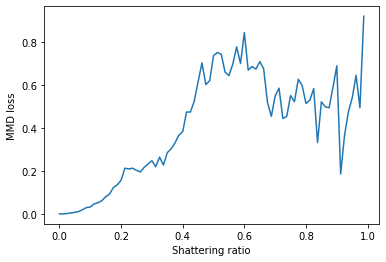

In [10]:
import random
import matplotlib
import matplotlib.pyplot as plt

data_1 = []
data_2 = []
for i, idx in enumerate(indices, 1):
    data_1.append(data[idx,:])
    data_2.append(data[random.sample(range(0, len(data)), intervel*i), :])

mmd_scores = []

for i in range(len(data)//intervel):
    mmd_scores.append(mmd_rbf(torch.Tensor(data_1[i]), torch.Tensor(data_2[i])))

shattering_ratio = [(1 - intervel*i/len(data)) for i in range (1,len(data)//intervel + 1)]

plt.plot(shattering_ratio, mmd_scores)
plt.xlabel('Shattering ratio')
plt.ylabel('MMD loss')
plt.show()